# Perform Steady-State River and zonal vulnerability

<u>__Description :__</u>

This tutorial will expose a river and a zonal vulnerability analysis from a `MODFLOW6` unstructured model (DISV-like) using backward particle tracking (`MODPATH7`).

- <u>__Required :__</u>
    - Executables : `mf6, mp7, gridgen`
    - Packages : `os, sys, numpy, pandas, flopy, geopandas, shapely, matplotlib, mpl_toolkits, time`
    - file(s) : `vulnerability.py / build_model.py`
    - folder : `sig / exe`
***
- <u>__Overview :__</u>
    1. Settings
    2. Introduction
    3. Loading & Run water flow model
    4. Particle preprocessing
    5. Build & Run transport model
    6. Rivers vulnerability
    7. Zonal vulnerability

### PART 1 : Setup the Notebook Environment

In [1]:
# ---- Install librairies if required
'''
!pip3 install numpy
!pip3 install pandas
!pip3 install flopy
!pip3 install geopandas
!pip3 install shapely
!pip3 install matplotlib
!pip3 install mpl_toolkits
'''

'\n!pip3 install numpy\n!pip3 install pandas\n!pip3 install flopy\n!pip3 install geopandas\n!pip3 install shapely\n!pip3 install matplotlib\n!pip3 install mpl_toolkits\n'

In [3]:
# ---- Built-in module and local settings
import os, sys
sys.path.append(os.path.join(os.getcwd(),'..'))
sig_dir = 'sig'
exe_dir = os.path.join('..','exe')
gridgen_exe = os.path.join(exe_dir, 'gridgen.exe')
mf6_exe = os.path.join(exe_dir, 'mf6')
mp7_exe = os.path.join(exe_dir, 'mp7')

# ---- Import packages
import numpy as np
import time
import pandas as pd
import flopy
from flopy.utils.gridgen import Gridgen
import geopandas as gpd
import shapely
shapely.speedups.disable()
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
%matplotlib inline

# ---- Print used version of each packages
print(sys.version)
print('geopandas version: {}'.format(gpd.__version__))
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('geopandas version: {}'.format(gpd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
geopandas version: 0.8.1
numpy version: 1.19.2
flopy version: 3.3.3
geopandas version: 0.8.1
matplotlib version: 3.2.2


### PART 2 : Introduction

The present syntethic model tends to represent a extremly simplify case of groundwater withdraw management on a zone highly influenced by human activities. Note that the majority of boundary conditions was created for tutorial modelisation purpose only. The model extension is a regular rectangle of `3.75 km` of width and `5 km` of height. All of this extension is considered as active for the model simulation (active domain). The spatial discretisation of the model is DISV-like with a `50*50m` resolution with nested refined parts (levels 2) around river, well and drain conditions. A flow borders conditions is set on south border of the model domain as a Constant Head Dirichlet conditions (*CHD*). The model contains a simple river divides into 3 reaches : *r1*, *r2*, *r3*. Ground water withdrawals are represented in the model by 2 pumping wells (*w1*, *w2*) and a `400m` long drain (*d1*) pumps drinking water in an unique productive aquifer.

<div>
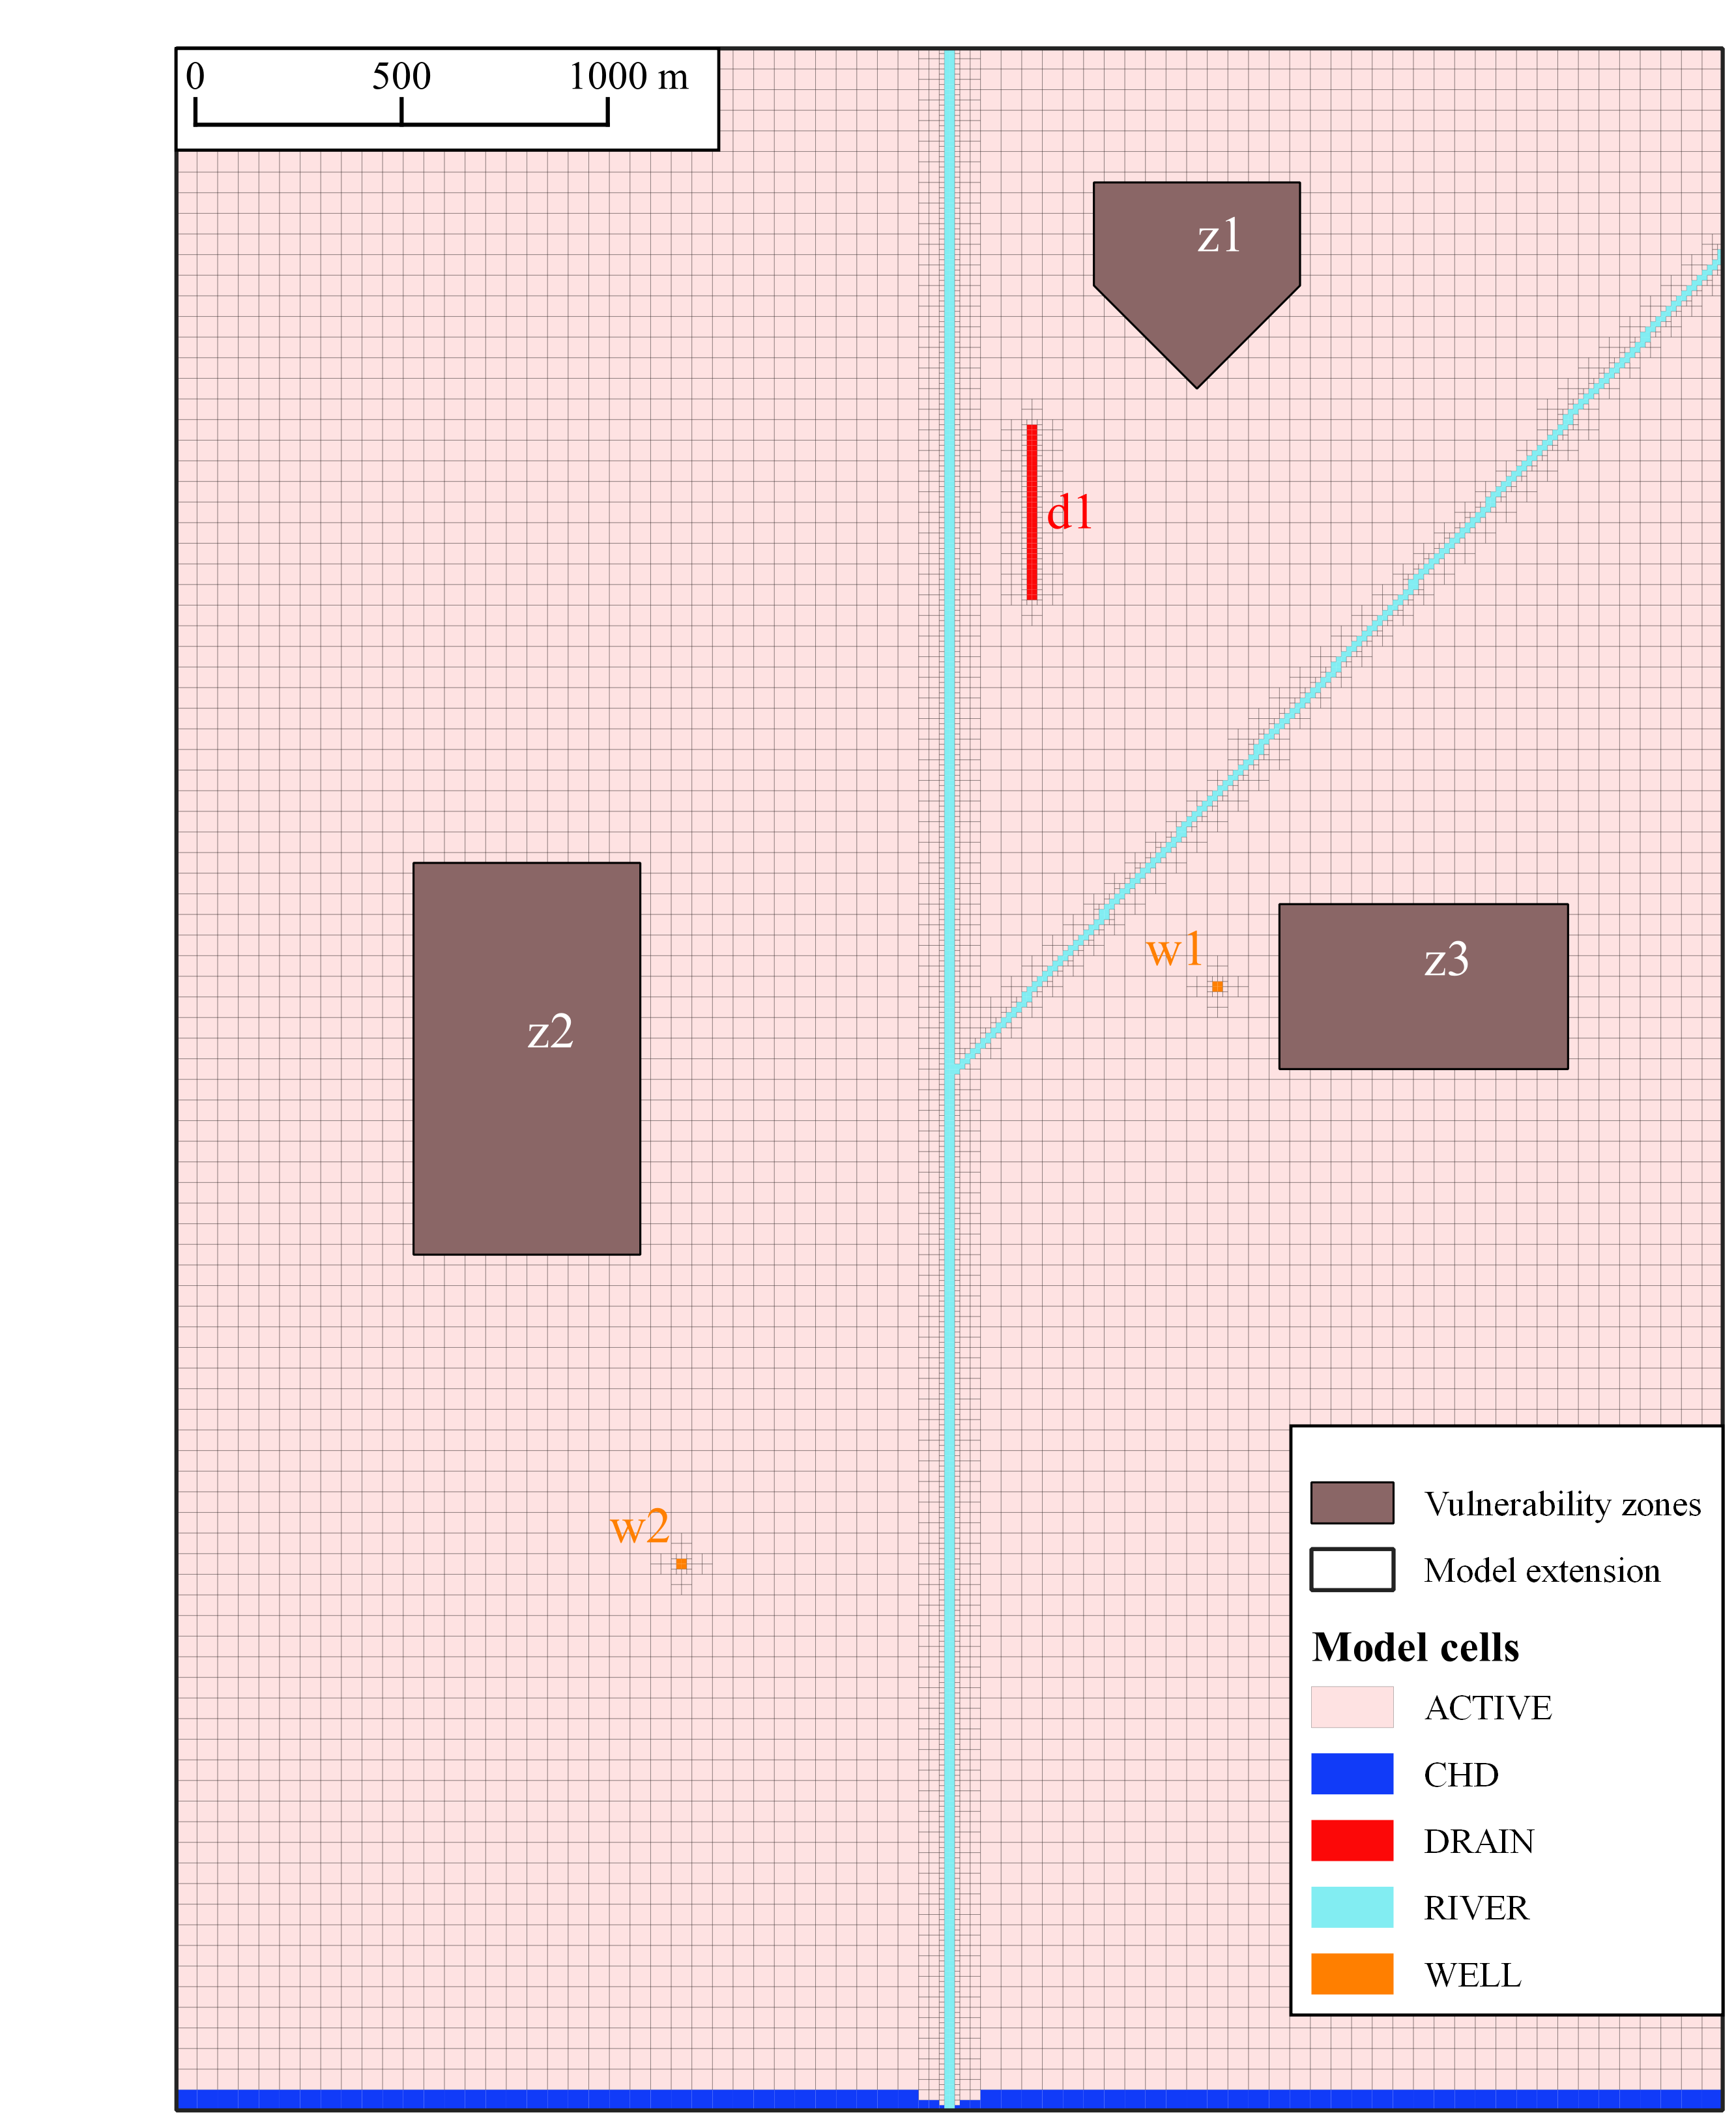
</div>

<div>
   <img src="attachment:intro_synmodel.png" width="300">
</div>

### PART 3 : Loading & Run ground water flow model

The modflow6 files of the model had already been created in the current folder. If you're interested to explore deeper the model construction, make sure to have a look on the `build_model.py` file. 
For now let's just load the `syn_model`.

####  Load MODFLOW6 Model

In [4]:
# ---- Load MFSimulation object
model_name = 'syn_model'
sim = flopy.mf6.MFSimulation.load(model_name)

# ---- Set mf6 executable
sim.exe_name = mf6_exe

# ---- Fetch ModflowGwf object
gwf = sim.get_model(model_name)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package wel...
    loading package rch...
    loading package oc...
  loading ims package syn_model...


#### Run ground water flow model

In [5]:
# ---- Run simulation 
sim.run_simulation()

FloPy is using the following  executable to run the model: ..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

   MODFLOW 6 compiled Dec 12 2019 13:30:12 with IFORT compiler (ver. 19.0.5)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Softwar

(True, [])

#### Plot heads results 

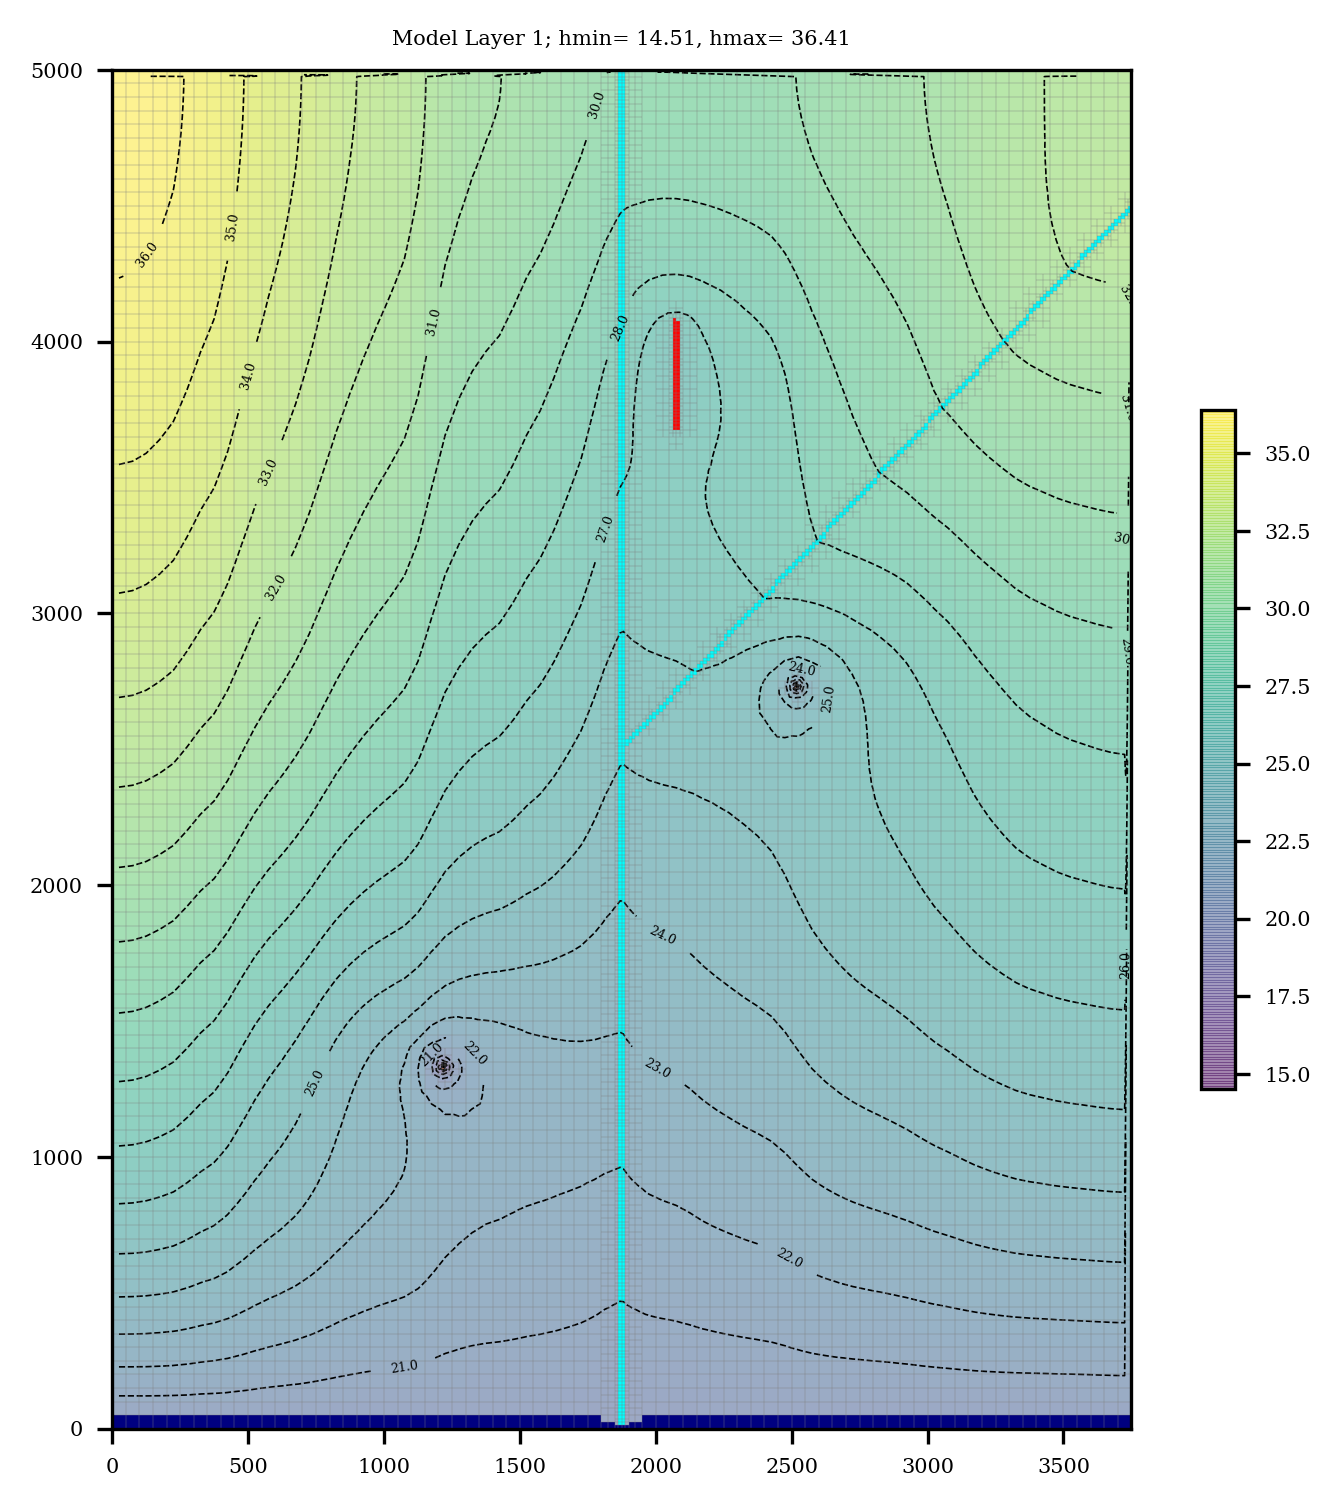

In [5]:
# ---- Set required layer
ilay = 0

# ---- Fetch heads data
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,ilay,-1,:]

# ---- Set plot figure
mpl.rcParams['figure.dpi'] = 300
plt.rc('font', family='serif', size=7)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect = 'equal')
ax.tick_params(axis='both', which='major', labelsize=5)

# ---- Build MapPlotView object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)

# ---- Plot head data
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)
cb = plt.colorbar(heads, shrink = 0.5)
cb.ax.tick_params(labelsize=5)

# ---- Plot contours
hmin, hmax = hds.min(), hds.max()
levels = np.arange(np.floor(hmin), np.ceil(hmax), 1)
contours = pmv.contour_array(hds, masked_values=[1.e+30], 
                                  levels=levels, linewidths = 0.4,
                                  linestyles = 'dashed', colors = 'black')
contours.clabel(fmt = '%1.1f', inline=True, colors = 'black', inline_spacing = 20, fontsize = 3)

# ---- Set boundaries colors
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy', 'WEL': 'coral'}
for bc in bc_colors_dic.keys():
        quadmesh = pmv.plot_bc(bc, color = bc_colors_dic[bc])
        
# ---- Set title
ax.set_title('Model Layer {}; hmin={:6.2f}, hmax={:6.2f}'.format(ilay + 1, hmin, hmax), fontsize = 5)

# ---- Plot grid
pmv.plot_grid(lw = 0.05)

### PART 4 : Seeding particle preprocessing 

This part will show an example of how to generate particles from vulnerable water production boundaries as wells or drains.
For that, the **vulnerability.py** file which contains some usefull tools is required and has to be import properly.

In [6]:
# ---- Import vulnerability utilities
from vulnerability import ParticleBuilder, ParticleMerger

#### Generate particles

The `ParticleBuilder` tool allows to generate/seed some particles with different methods and get some usefull spatial informations. To initiate a `ParticleBuilder` instance at least 3 arguments are needed:
- `name` : the name of the current `ParticleBuilder` instance (ex: name of a well or several wells)
- `gwf` : the Modflow6 flow model object (`flopy.mf6.mfmodel.MFModel`)
- `shp_name` or `geometry_dic` : the spatial object(s) to focus on (can be a shapefile or a dictionary with shapely names and geometries)

In [7]:
# ---- Fetch all shapefiles in a dictionary
shpfiles = [f for f in os.listdir(sig_dir) if f.endswith('.shp')]
shp_dic = {f.split('.')[0] : os.path.join(sig_dir,f) for f in shpfiles}

# ---- Create a ParticleBuilder instance for wells
pb_wells = ParticleBuilder(name = 'WELLS', gwf = gwf, shp_name = shp_dic['wells'], field_id = 'FID')

# ---- Create a ParticleBuider instance for drains
pb_drns = ParticleBuilder(name = 'DRAINS', gwf = gwf, shp_name = shp_dic['drain'], field_id = 'FID')


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


Note:
- The `ParticleBuilder` instance allows to provide ` flopy Gridgen` object used to build the model grid as an optional argument (`g`). That generally speeds up several methods of the `ParticleBuilder` instance such as seeding or extract informations from particules.
- To sum up the `ParticleBuilder`'s content object make sure to perform the `print()` function.

In [8]:
# ---- Show informations about ParticleBuilder instances created
print(pb_wells)
print(pb_drns)



                                      MODPATH7 Particle Builder Class
-----------------------------------  -----------------------------------
Particle Builder name                WELLS
Particle Builder field ID            FID
Particle Builder number of geometry  2
Particle Builder geometry names      w1, w2




                                      MODPATH7 Particle Builder Class
-----------------------------------  -----------------------------------
Particle Builder name                DRAINS
Particle Builder field ID            FID
Particle Builder number of geometry  1
Particle Builder geometry names      d1




To generate particles from a geometry, 2 methods are available:
- `around` : generate *N* particles regularly spaced at a given distance from the `ParticleBuilder` geometry(ies) 
- `within` : generate *N* particles as a regular mesh from the `ParticleBuilder` geometry(ies)

Let's examine the results of generating 200 particles 20m away from the well `w1` of the model with the `around` methods.

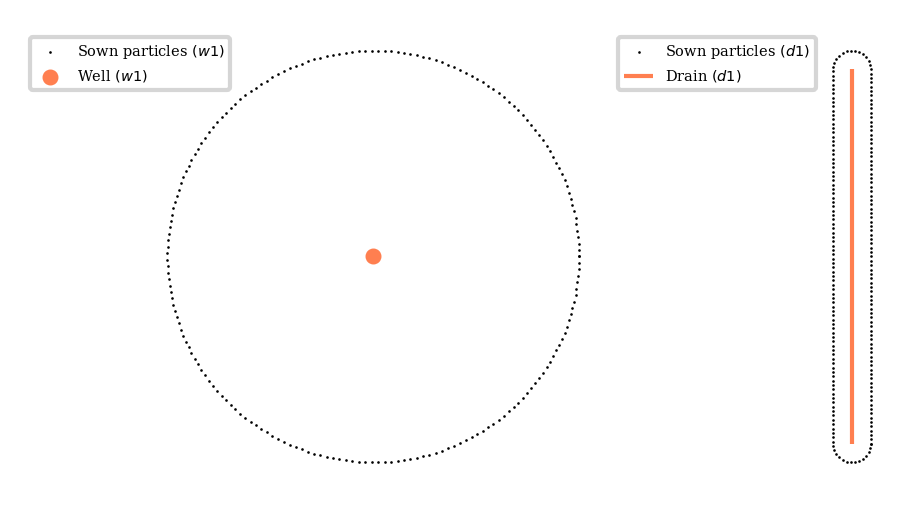

In [15]:
# ---- Generate 200 regularly spaced particles from the well 'w1' (20m)
well_gdf = pb_wells.gen_npart(dist = 20, n_part = 200, gen_type = 'around', fid = 'w1')

# ---- Generate 200 regularly spaced particles from the drain 'd1' (20m)
drn_gdf = pb_drns.gen_npart(dist = 20, n_part = 200, gen_type = 'around', fid = 'd1')

# ---- Plot generated particles
mpl.rcParams['figure.dpi'] = 300
plt.rc('font', family='serif', size=7)
fig = plt.figure(figsize=(5,2))
axs = fig.subplots(1,2, gridspec_kw={'wspace': -0.3})

well_gdf.plot(ax=axs[0],lw=0, markersize=0.4 , color = 'black',
                     label = "Sown particles $(w1)$")
coo = [[p.x,p.y] for p in pb_wells.shp.geometry][0]
axs[0].scatter(*coo, color = 'coral', label = "Well $(w1)$", s=8)
axs[0].legend(fontsize = 3.5,  bbox_to_anchor=(0.20, 1))

drn_gdf.plot(ax = axs[1], lw=0, markersize=0.4 , color = 'black',
                     label = "Sown particles $(d1)$")
pb_drns.shp.plot(ax=axs[1], lw=1,color = 'coral', label = "Drain $(d1)$")
axs[1].legend(fontsize = 3.5,  bbox_to_anchor=(-0.2, 1))

# ---- Remove axis borders
for ax in axs:
    ax.axis('off')

Note: The `within` method is **not really recommended** for a vulnerability analysis.

#### Save particles as shapefile

Sometimes it can be be usefull to get the generated particles as shapefile. There are 2 easy ways to do it:
- Using the basic geopandas `.to_file()` method
- Using the `ParticleBuilder` `export` argument while generating particles

In [10]:
# ---- Set shapefile filenames
w1_filename = os.path.join(sig_dir, 'particles', 'w1_particles.shp')
drn_filename = os.path.join(sig_dir, 'particles', 'drain_particles.shp')

# 1) to_file() method
well_gdf.to_file(w1_filename)

# 2) export argument
drn_gdf = pb_drns.gen_npart(dist = 20, n_part = 200, export = drn_filename)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


 Shapefile successfully wrote in sig\particles\drain_particles.shp


#### Extract particles data

To spatialize generated particles into the model grid, 4 informations of each particle are needed:
  - `locs` : node number of the cell in which the particule was generated
  - `local_x` : x-coordinate of the particule into the cell
  - `local_y` : y-coordinate of the particule into the cell
  - `pid` : unique particle id

Let's generate 1000 particles around each vulnerable boudary (wells and drain). To prevent the particles from stopping directly at a strong source during first timestep, it is preferable to set a suitable distance of particle generation from the boudary. The distance to choose to seed particules away from the production point (well or drain) is a delicate subject. It is up to the operator to find the best distance taking in account the capture zone of the facilities and the grid resolution of the model.

In this case we will consider that the minimum particle sowing distance must be strictly greater than the diagonal of the cell where the production facility is set.
So, let's assume that : *`generation distance > boundary cell resolution * sqrt(2)`*

In [16]:
# ---- Fetch wells node numbers
well_data = gwf.wel.stress_period_data.get_data(0)
well_nodes = {well_id:cellid[1] for cellid, well_id in zip(well_data['cellid'], well_data['boundname'])}

# ---- Fetch cells resolution
res_dic = pb_wells.get_res_dic()
well_res = {well_id: res_dic[well_node] for well_id, well_node in well_nodes.items()}

# ---- Print resolution per well
for well_id, res in well_res.items():
    print(f"Resolution of well '{well_id}' is {res}m")

Resolution of well 'w1' is 12.5m
Resolution of well 'w2' is 12.5m


In [17]:
# ---- Compute limit sowing distance dist_l = res * sqrt(2)
dist_l = (max(well_res.values()) * np.sqrt(2))
          
# ---- Set sowing distance dist > dist_l
tol = 0.1 # tolerance (m)
dist = dist_l + tol

print(f'The choosen sowing distance is {round(dist,2)}m')

The choosen sowing distance is 17.78m


In [18]:
# ---- Extract particles data
well_df = pb_wells.get_particle_df(dist = dist, n_part = 1000)
drn_df =  pb_drns.get_particle_df(dist = dist, n_part = 1000)
well_df.head()

FID  locs   local_x   local_y  pid
0  w1  5355  0.422214  0.000000    0
1  w1  5361  0.421775  0.991069    1
2  w1  5361  0.421336  0.982139    2
3  w1  5361  0.420897  0.973208    3
4  w1  5361  0.420459  0.964278    4

#### Build ParticleGroups

The `ParticleBuilder` instance is based on particle management that means generating particles for each facilities or group of facilities such as wells or drains and extracting the model grid information about their locations. Now, it's time to:
1. Merge all generated particles informations
2. Build `flopy ParticleGroup` instances to implement in `Modpath` simulation 

The `ParticleMerger` instance is a very simple wrapper to get this job done.

In [19]:
# ---- Merge all particles data
pm = ParticleMerger([well_df, drn_df])
display(pm.particle_df[::250])

FID  locs   local_x   local_y   pid
0     w1  5355  0.422214  0.000000     0
250   w1  5359  0.997767  0.577896   250
500   w1  5350  0.578006  0.004465   500
750   w1  5352  0.006698  0.421885   750
1000  w2  8080  0.422214  0.000000  1000
1250  w2  8084  0.997767  0.577896  1250
1500  w2  8075  0.578006  0.004465  1500
1750  w2  8077  0.006698  0.421885  1750
2000  d1  3075  0.422214  0.000000  2000
2250  d1  2654  0.577786  0.785141  2250
2500  d1  1966  0.579578  0.036459  2500
2750  d1  2393  0.422214  0.178357  2750

In [20]:
# ---- Build MODPATH7 ParticleGroup instances
particlegroups = [pm.get_ParticleGroup(fid = fid) for fid in pm.get_fids()]

C:\Users\pmatran\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


###  PART 5 : Build & Run backward particle tracking model

#### Build MODPATH7 Model 

In [21]:
# ---- Choose a name for modpath model
mpname =  'mp_rv'

# ---- Build MODPATH7 model instance
mp = flopy.modpath.Modpath7(modelname= mpname, flowmodel= gwf, exe_name= mp7_exe)

# ---- Set default iface for MODFLOW 6
defaultiface6 = {'RCH': 6, 'EVT': 6}

# ---- Build MODPATH7 BAS package
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1, defaultiface=defaultiface6)

# ---- Build MODPATH7 SIM package
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                      trackingdirection='backward',
                                      weaksinkoption='stop_at',
                                      weaksourceoption='stop_at',
                                      budgetoutputoption='summary',
                                      stoptimeoption='extend',
                                      particlegroups= particlegroups)

#### Write and Run MODPATH7 simulation

In [22]:
# ---- Write modpath files
mp.write_input()

# ---- Run modpath
mp.run_model()

FloPy is using the following  executable to run the model: ..\exe\mp7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
      1102 particles terminated at weak source cells.
      1898 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Plot pathlines

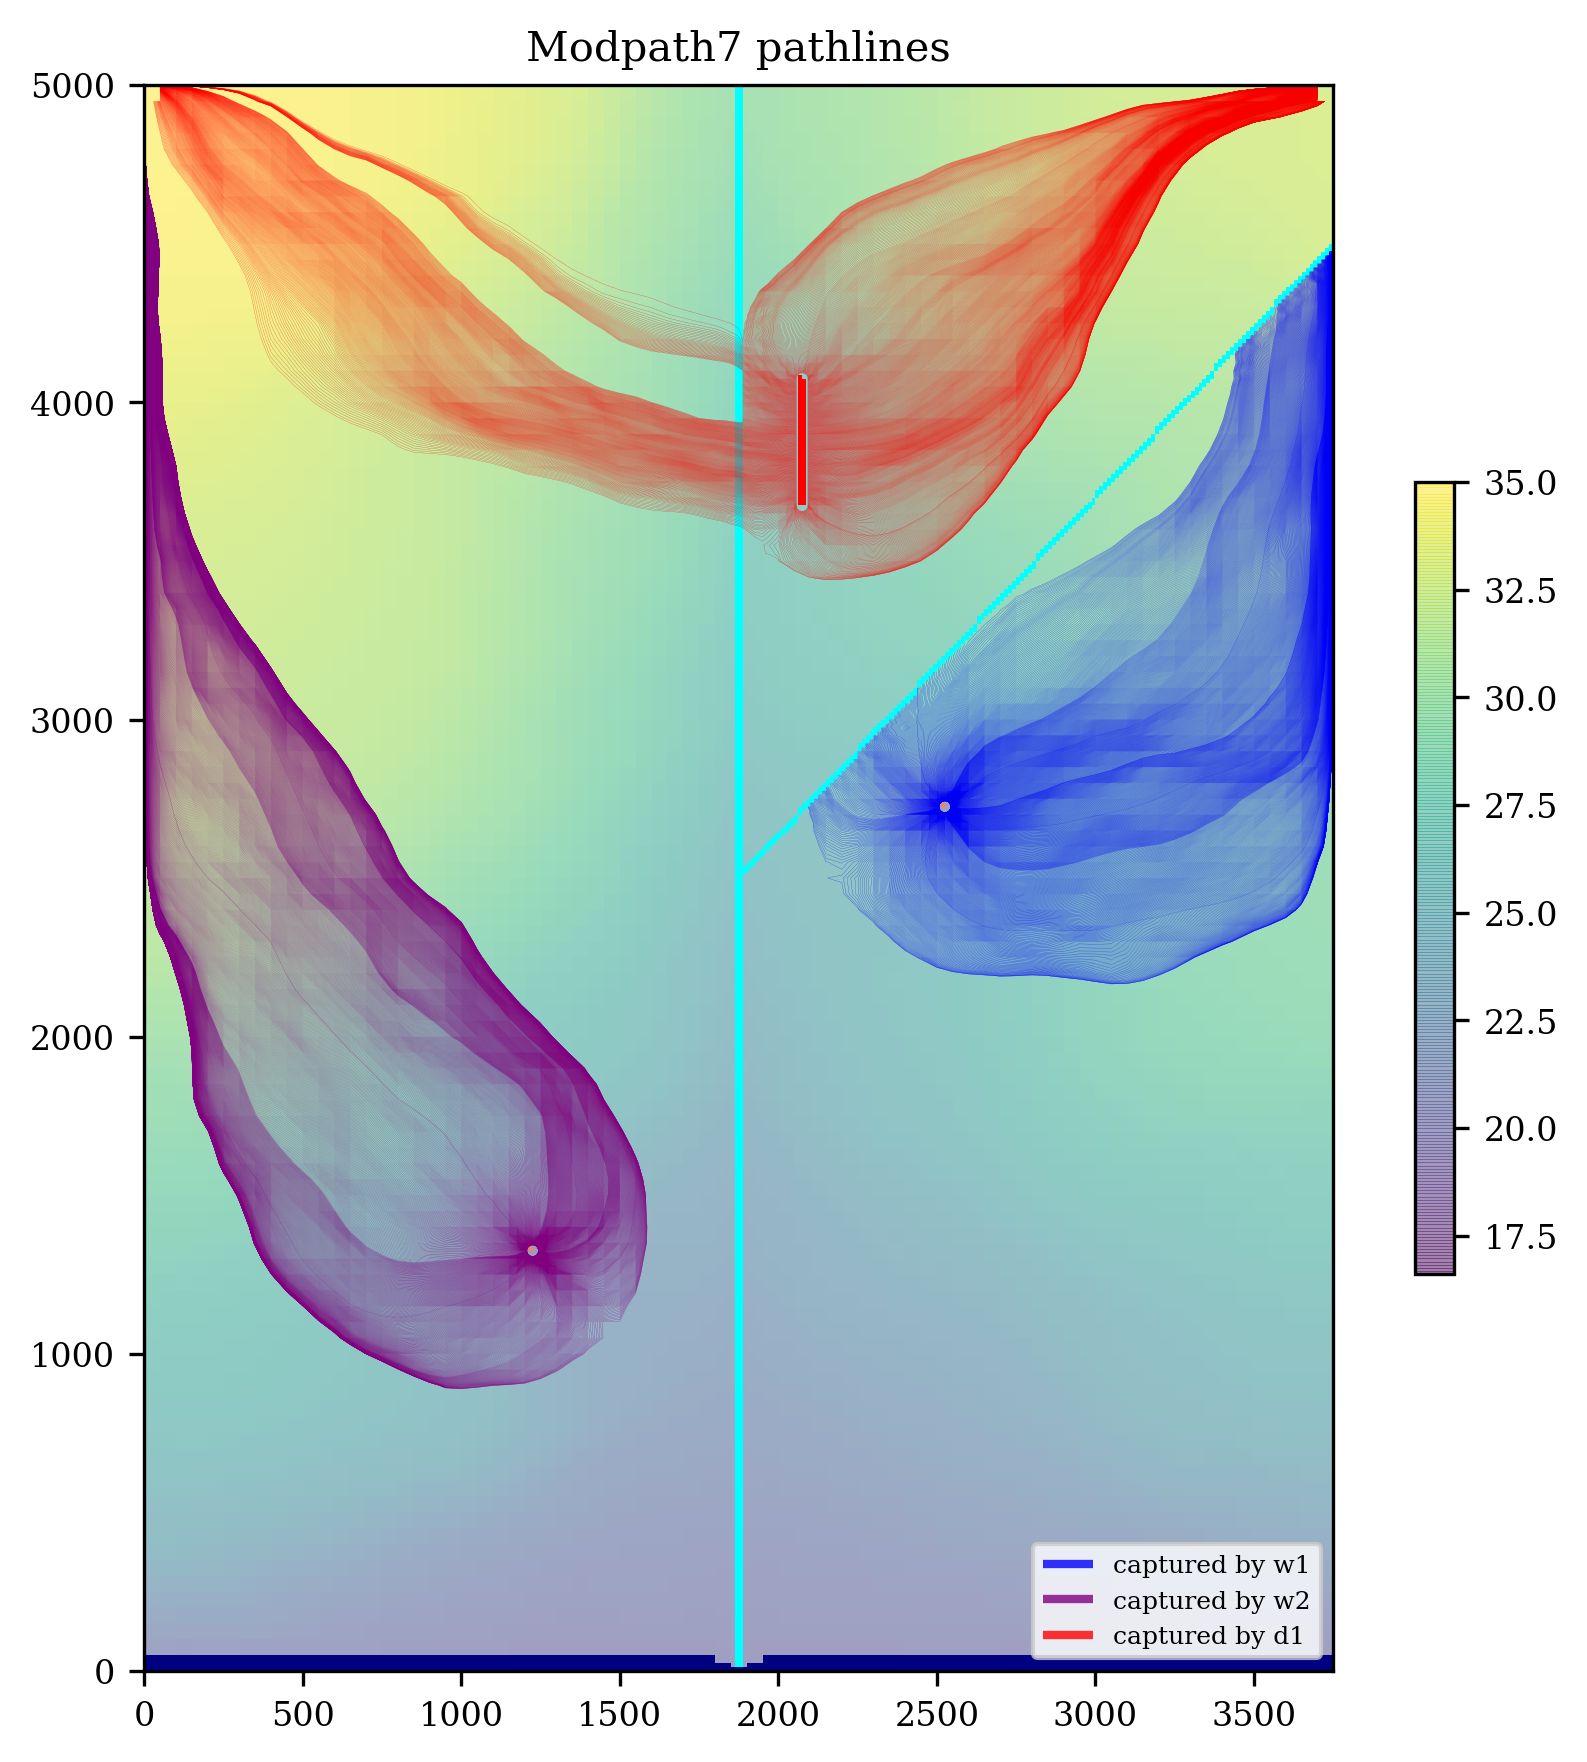

In [23]:
# ---- Prepare axes for plot
mpl.rcParams['figure.dpi'] = 300
plt.rc('font', family='serif', size=8)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Modpath7 pathlines' , fontsize=10)
 
# ---- Create Plot Map View object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_grid(lw = 0)
    
# ---- Plot heads as background
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,-1,-1,:]
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)
cb = plt.colorbar(heads, shrink = 0.5)

# ---- Plot pathlines for each group
pth = flopy.utils.PathlineFile(mpname + '.mppth')
colors = ['blue', 'purple', 'red']
for pg, c in zip(particlegroups, colors):
    nodes = pg.particledata.particledata.node
    rec = pth.get_destination_pathline_data(nodes) 
    pmv.plot_pathline(rec, color = c, layer = 'all', lw = 0.03, alpha = 0.8,
                    label=f'captured by {pg.particlegroupname}')
# ---- Plot boundaries
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy', 'WEL': 'coral'}
for bc in bc_colors_dic.keys():
    bounds = pmv.plot_bc(bc, color = bc_colors_dic[bc])
    
# ---- Plot legend
leg = ax.legend(loc = 'lower right',fontsize = 6)
for line in leg.get_lines():
    line.set_linewidth(2)

### PART 6 : River vulnerability

Now let's focus on the river vulnerability of the water production facilities (wells and drain) by importing the `SSRV` *(Steady-State River Vulnerability)* tool. To build a `SSRV` instance 2 objects are needed:
- `gwf`: the ground water flow model (`flopy.mf6.mfmodel.MFModel`) 
- `mpsim`: the advective transport simulation (`flopy.modpath.mp7sim.Modpath7Sim`)

#### Create a SSRV objet (Steady-State River Vulnerability)

In [24]:
# ---- Import Steady-State River Vulnerability instance
from vulnerability import SSRV

# ---- Create SSRV object
ssrv = SSRV(gwf = gwf, mpsim = mpsim)
print(ssrv)



                          Steady-State River Vulnerability Class
-----------------------  ------------------------------------------
Ground Water Flow model  syn_model
Number of river reaches  3
Names of river reaches   r1, r2, r3
Particle Group names     w1, w2, d1
Particle Group ids       0, 1, 2




Note: Make sure that all the river cells on the `riv` package of the modflow ground water flow model has a `boundname` argument. If the river is not divided in reaches, just make sure to put a basic name such as `'river'`.

The `SSRV` object has many usefull attributs such as:
  - `pth` : Pathline data
  - `edp` : Endpoint data
  - `cbc` : CellBudget data
  - `river_leakage_df` : DataFrame with leakage data for each river cell
  - `flowja`, `ia` : cells connectivity

#### Compute mixing ratios

`SSRV` object allows computing the fraction of water that comes from the river at a given production point like a well or a drain. The value of the mixing ratio may range between **0** (ground water only) to **1** (surface water only).

For going further about mixing ratios : [Cousquer et al, 2018](https://hal.archives-ouvertes.fr/hal-02308252/ "Developing a particle tracking surrogate model to improve inversion of ground water Surface water models")


In [25]:
# ---- Compute mixing ratio 
mr_df = ssrv.compute_mixing_ratio(filled = True)

# ---- Transform to percent
mr_df = mr_df * 100
display(mr_df.round(decimals = 2))

C:\Users\pmatran\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\pmatran\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
E:\Mhyqadeau\article\particle_tracking_vulnerability\synmodel\..\vulnerability.py:968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

from_r2  from_r1  from_r3  from_ground_water
w1    50.38     0.00      0.0              49.62
w2     0.00     0.00      0.0             100.00
d1     0.00     5.18      0.0              94.82

#### Plot mixing ratio results

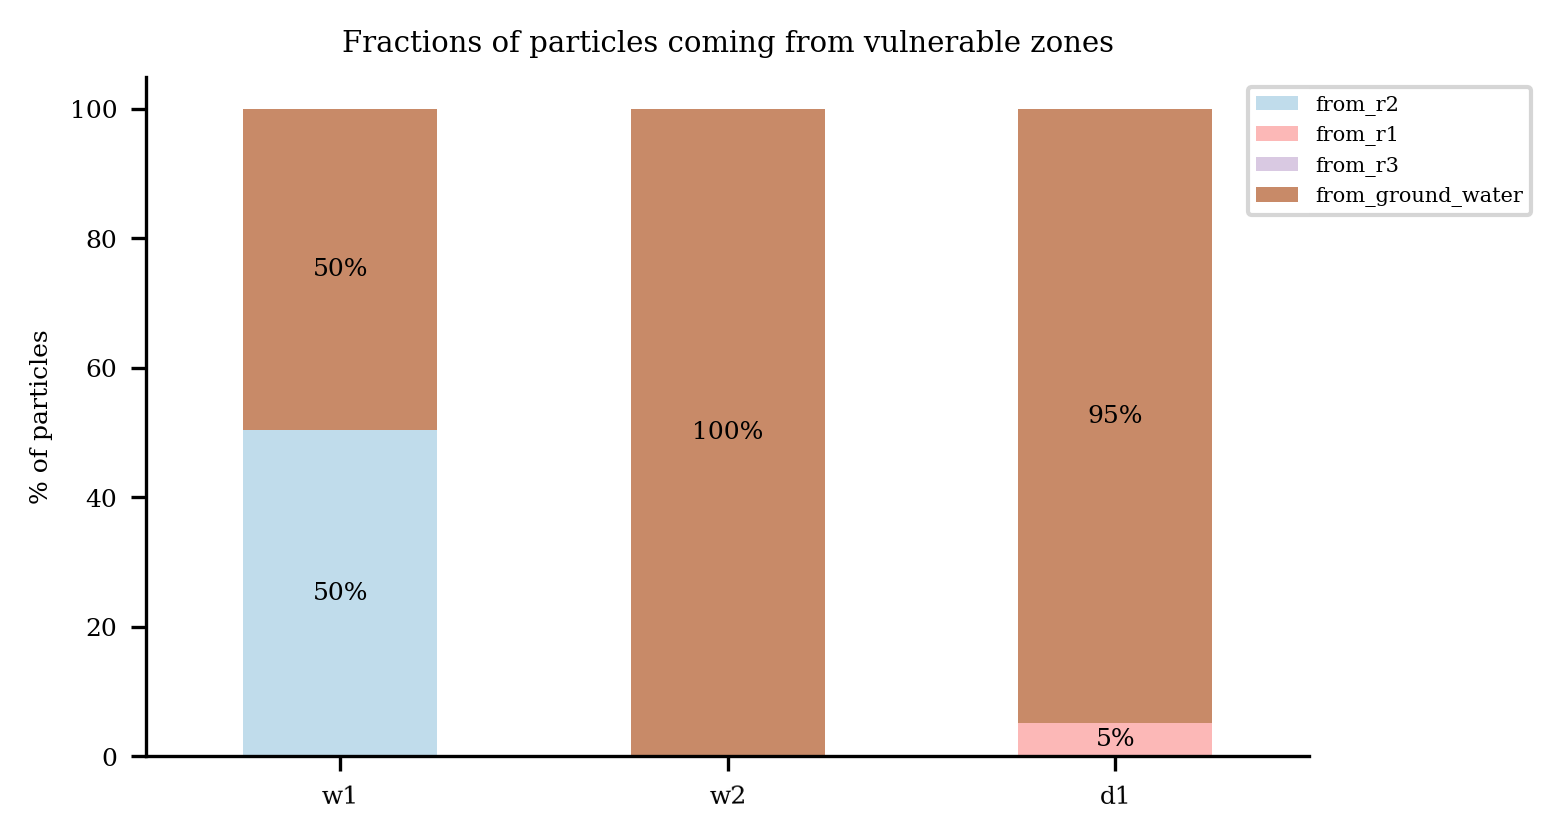

In [26]:
# ---- Prepare plot
plt.rc('font', family='serif', size=6)


# ---- Vertical bar plot
ax = mr_df.plot.bar(figsize=(5,3),cmap = 'Paired', stacked=True, alpha = 0.7, rot = 1)

# ----Set y-label
plt.ylabel('% of particles')

# ---- Set title
plt.title('Fractions of particles coming from vulnerable zones', fontsize = 7)

# ---- Add % in each bar
for p in ax.patches:
    # Write text only for % > 2
    if p.get_height() > 2:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, y+height/2, '{:.0f}%'.format(height),
        fontsize = 6, ha='center', va='center')

# ---- Hide axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ---- Show legend
plt.legend(loc = 'upper right',bbox_to_anchor=(1.2, 1), fontsize = 5)

#### Aggregate reaches

`SSRV` object allows computing mixing ratios aggregating multiple reaches. Let's try to aggregate all reaches into one river instance to get a general river vulnerability for all facilities.

In [27]:
# ---- Create a aggregation dictionary
agg_dic = {'river': ssrv.get_reach_names()}
print(agg_dic)

{'river': ['r2', 'r1', 'r3']}


In [28]:
# ---- Compute mixing ratio again
mr_df = ssrv.compute_mixing_ratio(agg_dic, filled = True)

# ---- Transform to percent
mr_df = mr_df * 100
display(mr_df.round(decimals = 2))

C:\Users\pmatran\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\pmatran\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
E:\Mhyqadeau\article\particle_tracking_vulnerability\synmodel\..\vulnerability.py:968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

from_river  from_ground_water
w1       50.38              49.62
w2        0.00             100.00
d1        5.18              94.82

#### Plot mixing ratio results after aggregating reaches

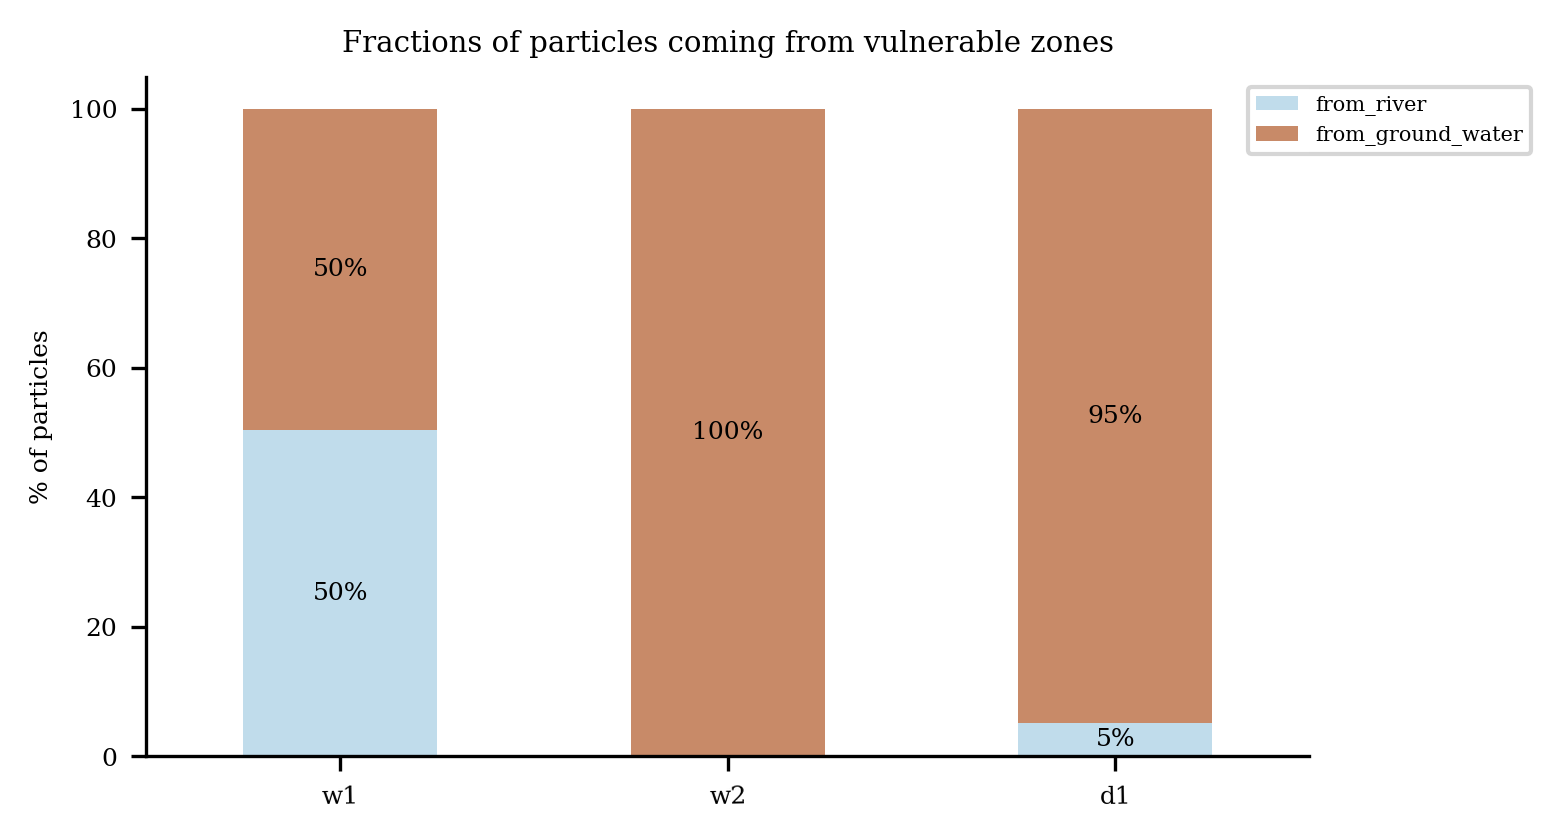

In [29]:
# ---- Prepare plot
plt.rc('font', family='serif', size=6)


# ---- Vertical bar plot
ax = mr_df.plot.bar(figsize=(5,3),cmap = 'Paired', stacked=True, alpha = 0.7, rot = 1)

# ----Set y-label
plt.ylabel('% of particles')

# ---- Set title
plt.title('Fractions of particles coming from vulnerable zones', fontsize = 7)

# ---- Add % in each bar
for p in ax.patches:
    # Write text only for % > 2
    if p.get_height() > 2:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, y+height/2, '{:.0f}%'.format(height),
        fontsize = 6, ha='center', va='center')

# ---- Hide axis
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ---- Show legend
plt.legend(loc = 'upper right',bbox_to_anchor=(1.2, 1), fontsize = 5)

### PART 7 : Zonal Vulnerability

Now let's focus on the zonal vulnerability of the water production facilities (wells and drain) by importing the `SSZV` *(Steady-State Zonal Vulnerability)* tool. To Build a `SSZV` instance 3 objects are needed:
- `gwf`: the ground water flow model (`flopy.mf6.mfmodel.MFModel`) 
- `mpsim`: the advective transport simulation (`flopy.modpath.mp7sim.Modpath7Sim`)
- `shp_name` or `geometry_dic`: shapefile path or dictionary of `shapely` geometries (polygon(s)) that contains vulnerability zones

####  Create a SSZV objet (Steady-State Zonal Vulnerability)

In [30]:
# ---- Import Steady-State River Vulnerability instance
from vulnerability import SSZV

# ---- Create SSZV object
sszv = SSZV(gwf = gwf, mpsim = mpsim,
            shp_name = shp_dic['vul_zones'],
            field_id = 'FID')

# ---- SSZV instance infos
print(sszv)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 85: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 96: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 86: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 91: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 90: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\pmatran\anaconda3\lib\site-packages\fiona\env.py", line 283, in defenv
    local._env.start()
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 88: invalid continuation byte




                                Steady-State Zonal Vulnerability Class
-----------------------------  ------------------------------------------
Number of vulnerability zones  3
Names of vulnerability zones   z1, z2, z3
Particle Group names           w1, w2, d1
Particle Group ids             0, 1, 2




#### Compute zonal vulnerability

`SSZV` tool allows to compute the number of particles that terminate in the water production facility from a given potential zone of contamination. This index can be calculate with or without ponderating the number of particle by their arrival velocity at the production point (`pond_velocity`). For an homogeneous hydraulic conductivity the velocity does not really matter.

In [31]:
# ---- Compute zonal vulnerability in percent with particle velocity ponderation
s = time.time()
zv_df = sszv.compute_zonal_vulnerability(pond_velocity = True) * 100
exe_time = round(time.time()  - s, 2)
print(f'Execution time for {len(sszv.edp.get_alldata())} particles with velocity ponderation: {exe_time}s')
display(zv_df.round(decimals = 2))

# ---- Compute zonal vulnerability in percent without particle velocity ponderation
s = time.time()
zv_df_without_v = sszv.compute_zonal_vulnerability(pond_velocity = False) * 100
exe_time = round(time.time()  - s, 2)
print(f'Execution time for {len(sszv.edp.get_alldata())} particles without velocity ponderation: {exe_time}s')
display(zv_df_without_v.round(decimals = 2))

Execution time for 3000 particles with velocity ponderation: 7.38s


from z2  from GW  from z3  from z1
w1     0.00    58.94    41.06     0.00
w2    55.71    44.29     0.00     0.00
d1     0.00    72.57     0.00    27.43

Execution time for 3000 particles without velocity ponderation: 0.3s


from z2  from GW  from z3  from z1
w1      0.0      0.0     56.4      0.0
w2     55.3      0.0      0.0      0.0
d1      0.0      0.0      0.0     21.3

Note: This is a **semi-quantitative spatial method** that give a index ratio as `number of captured particles / total number of sown particles` where all the particles that touch or cross a given potential polluted zone are considered contiminated. Of course, the result of this method cannot be robust as the mixing ratio with the river discussed earlier but it works as a additionnal **indicator** of vulnerability analysis and give some informations about connections between groundwater withdraw facilities and polluted zones.

#### Plots results

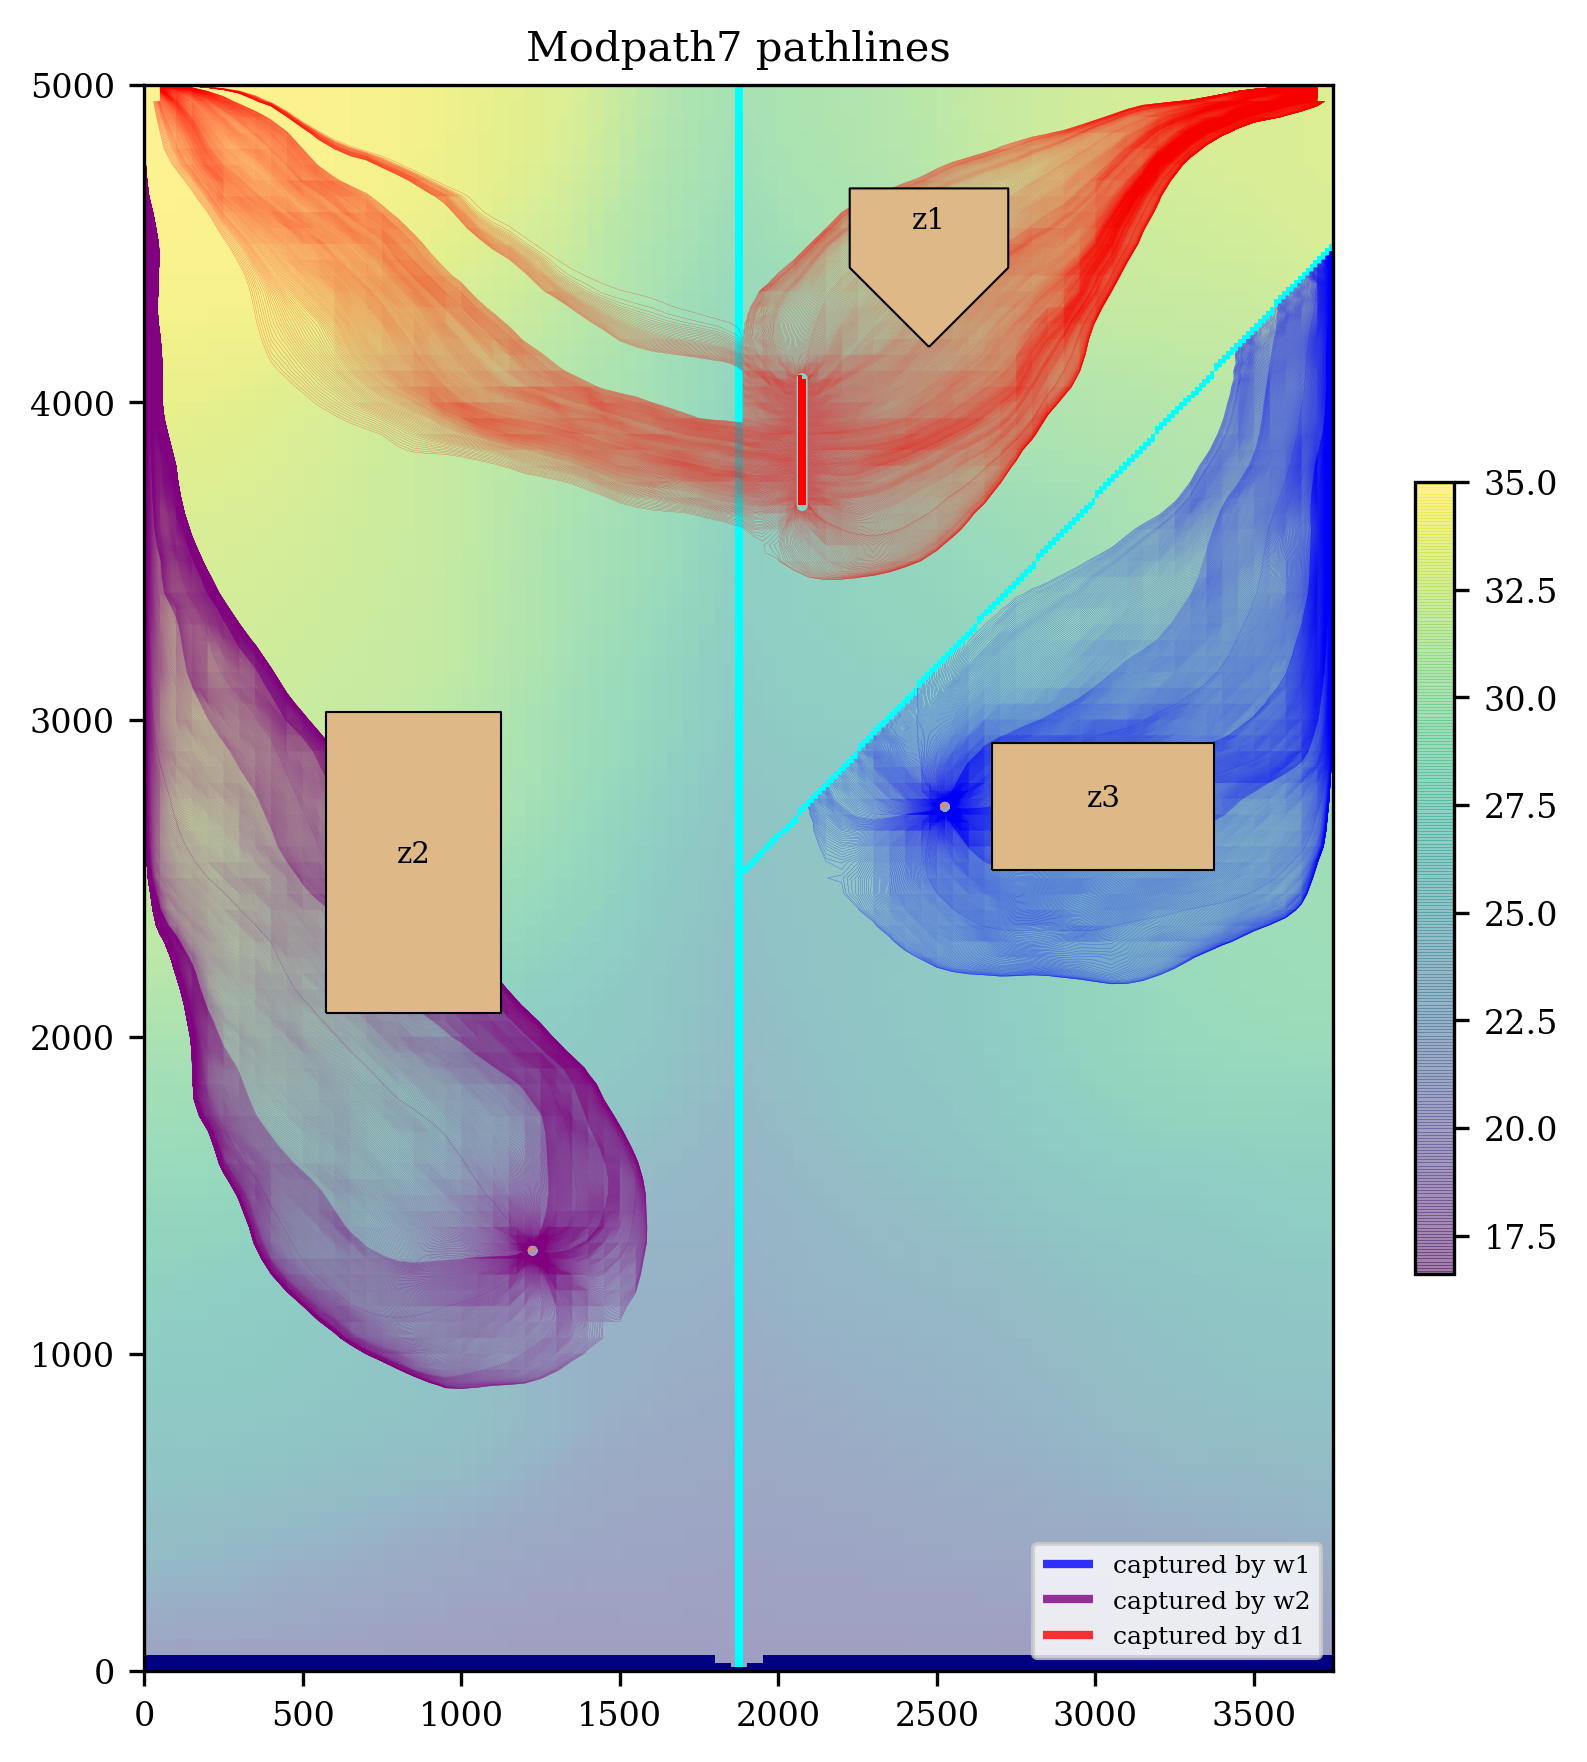

In [32]:
# ---- Prepare axes for plot
mpl.rcParams['figure.dpi'] = 300
plt.rc('font', family='serif', size=8)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Modpath7 pathlines' , fontsize=10)
 
# ---- Create Plot Map View object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_grid(lw = 0)

# ---- Plot zones
sszv.vul_zone.plot(ax = ax,color = 'burlywood', edgecolor="black", lw=0.5, zorder = 10)
coords = sszv.vul_zone['geometry'].apply(lambda x: x.representative_point().coords[:])
sszv.vul_zone['rp'] = [coords[0] for coords in coords]
for idx, row in sszv.vul_zone.iterrows():
    plt.annotate(s=row['FID'], xy=row['rp'],
                 horizontalalignment='center',
                 fontsize = 7,
                 color = 'black',
                 zorder = 50)

# ---- Plot heads as background
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,-1,-1,:]
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)
cb = plt.colorbar(heads, shrink = 0.5)

# ---- Plot pathlines for each group
pth = flopy.utils.PathlineFile(mpname + '.mppth')
colors = ['blue', 'purple', 'red']
for pg, c in zip(particlegroups, colors):
    nodes = pg.particledata.particledata.node
    rec = pth.get_destination_pathline_data(nodes) 
    pmv.plot_pathline(rec, color = c, layer = 'all', lw = 0.03, alpha = 0.8,
                    label=f'captured by {pg.particlegroupname}')
# ---- Plot boundaries
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy', 'WEL': 'coral'}
for bc in bc_colors_dic.keys():
    bounds = pmv.plot_bc(bc, color = bc_colors_dic[bc])
    
# ---- Plot legend
leg = ax.legend(loc = 'lower right',fontsize = 6)
for line in leg.get_lines():
    line.set_linewidth(2)

#### Multiple particle intersections

It may happen that a particle can cross successively several polluted areas. This makes the zonal vulnerability study even more complex. Let's investigate this part by keeping focus on the `z2` zone and adding a additionnal zone (can correspond to a pesticide storage warehouse for example) represented as a square polygon `(150m*150m)` named `z4` on the north west of the production well `w2`.

In [33]:
# ---- Fetch z2 zone geometry
z2_geom = sszv.vul_zone.loc[sszv.vul_zone[sszv.field_id] == 'z2', 'geometry'].values[0]

# ---- Build the new z3 zone
from shapely.geometry import Point
z4_geom = Point((850,1600)).buffer(150, cap_style = 3)

# ---- Create a new SSZV object
geom_dic = {vid:geom for vid,geom in zip(['z2', 'z4'],[z2_geom, z4_geom])}
sszv2 = SSZV(gwf = gwf, mpsim = mpsim, geometry_dic = geom_dic)

#### Plot venn diagram

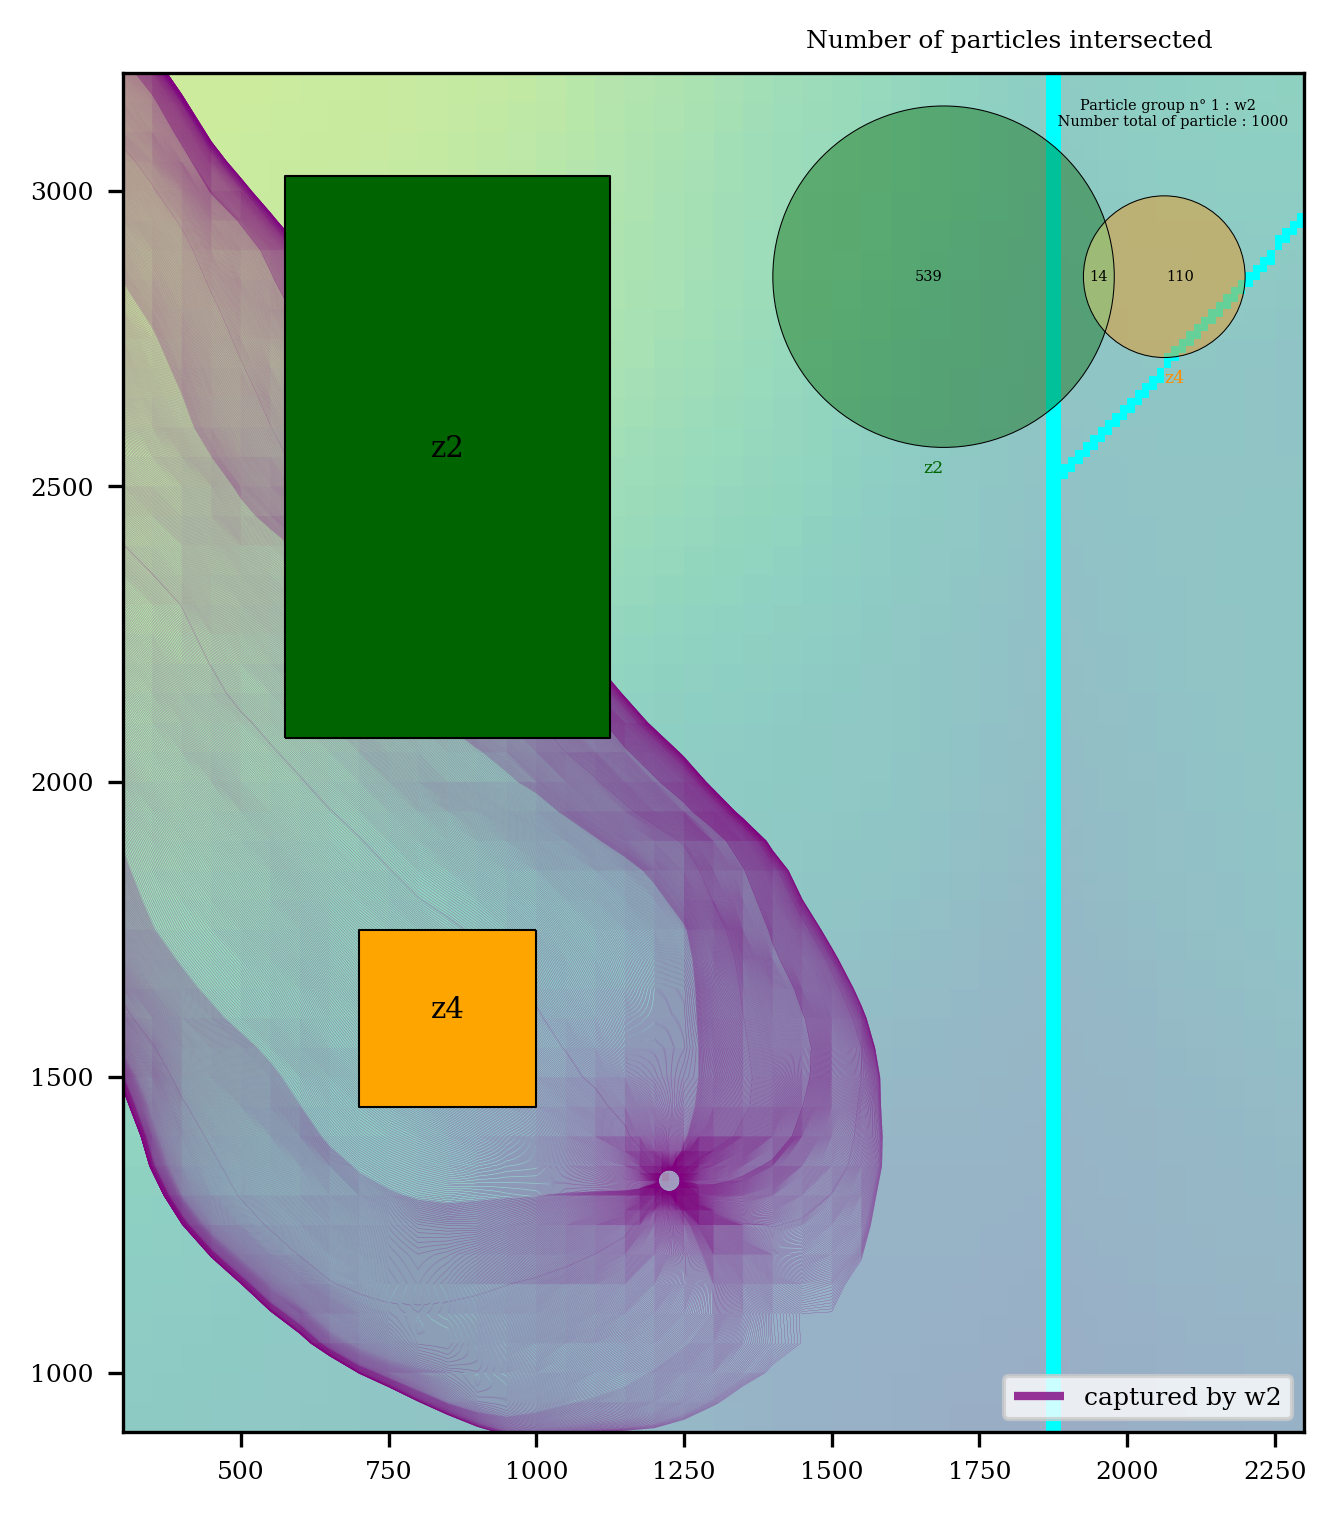

In [34]:
# ---- Prepare axes for plot
mpl.rcParams['figure.dpi'] = 300
plt.rc('font', family='serif', size=6)
fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(1, 1, 1, aspect='equal')

# ---- Create Plot Map View object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax0)
pmv.plot_grid(lw = 0)

# ---- Plot heads as background
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,-1,-1,:]
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)

# ---- Plot zones 
sszv2.vul_zone.plot(ax = ax0,color = ['darkgreen', 'orange'], edgecolor="black", lw=0.5, zorder = 10)
coords = sszv2.vul_zone['geometry'].apply(lambda x: x.representative_point().coords[:])
sszv2.vul_zone['rp'] = [coords[0] for coords in coords]
for idx, row in sszv2.vul_zone.iterrows():
    plt.annotate(s=row['FID'], xy=row['rp'],
                 horizontalalignment='center',
                 fontsize = 7,
                 color = 'black',
                 zorder = 50)

# ---- Plot pathlines for well w2
pth = flopy.utils.PathlineFile(mpname + '.mppth')
pg = [pg for pg in particlegroups if pg.particlegroupname == 'w2'][0]
rec = pth.get_destination_pathline_data(pg.particledata.particledata.node)
pmv.plot_pathline(rec, color = 'purple', layer = 'all', lw = 0.03, alpha = 0.8,
                    label=f'captured by {pg.particlegroupname}')

# ---- Plot boundaries
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy'}
for bc in bc_colors_dic.keys():
    bounds = pmv.plot_bc(bc, color = bc_colors_dic[bc])

# ---- Focus on z2, z4 areas
ax0.set_xlim((300,2300))
ax0.set_ylim((900,3200))

# ---- Plot legend
leg = ax0.legend(loc = 'lower right',fontsize = 6)
for line in leg.get_lines():
    line.set_linewidth(2)

# ---- Embedding venn diagram in main plot
embed_ax = inset_axes(ax0, width="50%",height='30%',loc=1, borderpad=0)
ax1,venn,circles = sszv2.plot_venn(ax = embed_ax, pg = 'w2',colors = ['darkgreen', 'darkorange'],
                                   lw = 0.25, alpha = 1, textsize=3.5)
embed_ax.set_title('Number of particles intersected', fontsize=6)
embed_ax.set_facecolor('black')

#### Manage multiple intersections zonal vulnerability

So, `539` particles out of the `1000` sown cross the `z2` zone, `110` particles cross the `z4` zone and `14` particles cross both areas. So, in order to calculate a unique understandable indicator 3 methods are available to manage this multiple intersections:
- `first` : consider only the first zone of vulnerability intersected
- `last`  : consider only the last zone of vulnerability intersected
- `all`   : consider all zones of vulnerability intersected

In [35]:
# ---- Compute zonal vulnerability for each intersection method
dfs = []
for method in sszv2.get_methods():
    df = sszv2.compute_zonal_vulnerability(method = method) * 100
    dfs.append(df.loc['w2'].to_frame().T)

# ---- Concatenate all results in a single Data Frame
zv_df = pd.concat(dfs)
zv_df.index = sszv2.get_methods()
display(zv_df)

from z2    from z4    from GW  from z2 & z4
all    55.705525  19.103724  27.207101       2.01635
first  55.705525  17.087374  27.207101           NaN
last   53.689175  19.103724  27.207101           NaN

Note: For the `all` method, a particle can be considerated multiple times: in `z2`,` z4` or `z2 & z4` zones. That's the reason why the general indicator can be more than `100%`.